# Восстановление золота из руды

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Используйте данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Вам нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

Чтобы выполнить проект, обращайтесь к библиотекам *pandas*, *matplotlib* и *sklearn.* Вам поможет их документация.

**Цель проекта:** предсказание коэффициента восстановления золота из золотосодержащей руды.

<br>**Задачи исследования:**
<br>1.Изучить исходные данные и выполнить их предобработку.
<br>2.Анализ данных.
<br>3.Построение модели.
<br>5.Сделать общий вывод.

## Подготовка данных

In [607]:
import pandas as pd
import seaborn as sns

In [608]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler 

In [609]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [610]:
# обучающая выборка
data_train = pd.read_csv('/datasets/gold_recovery_train_new.csv')
# тестовая выборка
data_test = pd.read_csv('/datasets/gold_recovery_test_new.csv')
# исходная выборка
data_full = pd.read_csv('/datasets/gold_recovery_full_new.csv')

In [611]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


In [612]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primary_clea

In [613]:
data_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                               19433 non-null  float64


Согласно описанию к данным:

Rougher feed — исходное сырье <br>
Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant <br>
Xanthate **— ксантогенат (промотер, или активатор флотации); <br>
Sulphate — сульфат (на данном производстве сульфид натрия); <br>
Depressant — депрессант (силикат натрия).<br>
Rougher process (англ. «грубый процесс») — флотация <br>
Rougher tails — отвальные хвосты <br>
Float banks — флотационная установка <br>
Cleaner process — очистка <br>
Rougher Au — черновой концентрат золота <br>
Final Au — финальный концентрат золота <br>

Параметры этапов <br>
air amount — объём воздуха<br>
fluid levels — уровень жидкости<br>
feed size — размер гранул сырья<br>
feed rate — скорость подачи<br>

Возможные значения для блока [этап]:<br>
rougher — флотация <br>
primary_cleaner — первичная очистка <br>
secondary_cleaner — вторичная очистка <br>
final — финальные характеристики <br>

Возможные значения для блока [тип_параметра]:<br>
input — параметры сырья<br>
output — параметры продукта<br>
state — параметры, характеризующие текущее состояние этапа<br>
calculation — расчётные характеристики<br>

### Проверка расчета эффективности обогащения на обучающей выборке

Проверим расчет эффективности обогащения.

In [614]:
def recovery(row):
    # доля золота в сырье/концентрате до флотации/очистки
    F = row['rougher.input.feed_au']
    # доля золота в отвальных хвостах после флотации/очистки 
    T = row['rougher.output.tail_au']
    # доля золота в концентрате после флотации/очистки
    C = row['rougher.output.concentrate_au']
    
    # эффективность обогащения
    result = (C*(F-T))/(F*(C-T))*100
    
    return result

С помощью функции выполним расчет эффективности обогащения, результаты добавим в столбец recovery.

In [615]:
data_train['recovery'] = data_train.apply(recovery, axis=1)

Вычислим МАЕ между рассчитанными и имеющимися значениями.

In [616]:
mean_absolute_error(data_train['rougher.output.recovery'], data_train['recovery'])

9.73512347450521e-15

МАЕ имеет небольшое значение, значит эффективность обогащения рассчитана верно.

### Анализ признаков, недоступных в тестовой выборке

Создадим списки с названиями доступных параметров для обучающей и тестовой выборки. 

In [617]:
train_columns = list(data_train.columns.values)
test_columns = list(data_test.columns.values)

Создадим список из наименований тех параметров, которые есть в обучающем датасете, но нет в тестовой выборке.

In [618]:
columns = []
for i in train_columns:
    if i not in test_columns:
        columns.append(i)
print(*columns, sep = '\n')

final.output.concentrate_ag
final.output.concentrate_pb
final.output.concentrate_sol
final.output.concentrate_au
final.output.recovery
final.output.tail_ag
final.output.tail_pb
final.output.tail_sol
final.output.tail_au
primary_cleaner.output.concentrate_ag
primary_cleaner.output.concentrate_pb
primary_cleaner.output.concentrate_sol
primary_cleaner.output.concentrate_au
primary_cleaner.output.tail_ag
primary_cleaner.output.tail_pb
primary_cleaner.output.tail_sol
primary_cleaner.output.tail_au
rougher.calculation.sulfate_to_au_concentrate
rougher.calculation.floatbank10_sulfate_to_au_feed
rougher.calculation.floatbank11_sulfate_to_au_feed
rougher.calculation.au_pb_ratio
rougher.output.concentrate_ag
rougher.output.concentrate_pb
rougher.output.concentrate_sol
rougher.output.concentrate_au
rougher.output.recovery
rougher.output.tail_ag
rougher.output.tail_pb
rougher.output.tail_sol
rougher.output.tail_au
secondary_cleaner.output.tail_ag
secondary_cleaner.output.tail_pb
secondary_cleaner.

Таким образом, получаем, что в тестовой выборке недоступны данные, характеризующие параметры получаемого продукта, а также значения концентрации после первичной очистки, расчетные характеристики.

### Предобработка данных

Проверим обучающую выборку на наличие дубликатов.

In [619]:
data_train.duplicated().sum()

0

Дубликаты не обнаружены. Проверим наличие пропусков в данных.

In [620]:
data_train.isna().mean()

date                                          0.000000
final.output.concentrate_ag                   0.000071
final.output.concentrate_pb                   0.000071
final.output.concentrate_sol                  0.014913
final.output.concentrate_au                   0.000000
                                                ...   
secondary_cleaner.state.floatbank5_b_air      0.000071
secondary_cleaner.state.floatbank5_b_level    0.000071
secondary_cleaner.state.floatbank6_a_air      0.000141
secondary_cleaner.state.floatbank6_a_level    0.000071
recovery                                      0.000000
Length: 88, dtype: float64

В данных есть пропуски, проверим есть ли параметры со значениями пропусков более 1 %.

In [621]:
data_train.isna().mean().to_frame(name="nans").query("nans > 0.01")["nans"]

final.output.concentrate_sol                0.014913
primary_cleaner.output.concentrate_sol      0.020213
rougher.input.feed_size                     0.010177
rougher.input.floatbank11_xanthate          0.030249
rougher.state.floatbank10_e_air             0.030815
secondary_cleaner.output.tail_sol           0.113436
secondary_cleaner.state.floatbank2_a_air    0.015337
Name: nans, dtype: float64

Заполним пропуски в переменной медианным значением.

In [622]:
data_train['secondary_cleaner.output.tail_sol'] = data_train['secondary_cleaner.output.tail_sol'].fillna(
    method='ffill') 

In [623]:
data_train.isna().mean().to_frame(name="nans").query("nans > 0.01")["nans"]

final.output.concentrate_sol                0.014913
primary_cleaner.output.concentrate_sol      0.020213
rougher.input.feed_size                     0.010177
rougher.input.floatbank11_xanthate          0.030249
rougher.state.floatbank10_e_air             0.030815
secondary_cleaner.state.floatbank2_a_air    0.015337
Name: nans, dtype: float64

Остальные пропущенные значения удалим.

In [624]:
data_train = data_train.dropna()

In [625]:
data_train.isna().mean().to_frame(name="nans").query("nans > 0")["nans"]

Series([], Name: nans, dtype: float64)

Проверим наличие пропусков в тестовой выборке.

In [626]:
data_test.isna().mean().to_frame(name="nans").query("nans > 0.001")["nans"]

rougher.input.feed_sol                      0.003970
rougher.input.floatbank11_sulfate           0.001512
rougher.input.floatbank11_xanthate          0.004726
secondary_cleaner.state.floatbank3_a_air    0.001701
Name: nans, dtype: float64

Поскольку количество пропусков менее 1%, то просто удалим их, чтобы не искажать результаты.

In [627]:
data_test = data_test.dropna()

In [628]:
data_test.isna().mean().to_frame(name="nans").query("nans > 0")["nans"]

Series([], Name: nans, dtype: float64)

Удалим пропуски из полной выборки.

In [629]:
data_full.isna().mean().to_frame(name="nans").query("nans > 0.01")["nans"]

final.output.concentrate_sol                0.010854
primary_cleaner.output.concentrate_sol      0.019034
rougher.input.floatbank11_xanthate          0.023304
rougher.state.floatbank10_e_air             0.022429
secondary_cleaner.output.tail_sol           0.089922
secondary_cleaner.state.floatbank2_a_air    0.011317
Name: nans, dtype: float64

In [630]:
data_full = data_full.dropna()

In [631]:
data_full.isna().mean().to_frame(name="nans").query("nans > 0")["nans"]

Series([], Name: nans, dtype: float64)

В выборке устранены пропуски, перейдем к анализу.

## Анализ данных

### Изменение концентрации металлов

Посмотрим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки.

In [632]:
rougher_input_concentrate_au = data_train['rougher.input.feed_au'].median()
rougher_output_concentrate_au = data_train['rougher.output.concentrate_au'].median()
final_concentrate_au = data_train['final.output.concentrate_au'].median()

au = [rougher_input_concentrate_au, rougher_output_concentrate_au, final_concentrate_au]

In [633]:
rougher_input_concentrate_ag = data_train['rougher.input.feed_ag'].median()
rougher_output_concentrate_ag = data_train['rougher.output.concentrate_ag'].median()
final_concentrate_ag = data_train['final.output.concentrate_ag'].median()

ag = [rougher_input_concentrate_ag, rougher_output_concentrate_ag, final_concentrate_ag]

In [634]:
rougher_input_concentrate_pb = data_train['rougher.input.feed_pb'].median()
rougher_output_concentrate_pb = data_train['rougher.output.concentrate_pb'].median()
final_concentrate_pb = data_train['final.output.concentrate_pb'].median()

pb = [rougher_input_concentrate_pb, rougher_output_concentrate_pb, final_concentrate_pb]

In [635]:
name = ['Концентрация в смеси золотоносной руды', 'Концентрация в черновом концентрате',
        'Концентрация в финальном концентрате']

In [636]:
data = {'name' : name,
        'au' : au,
        'ag' : ag,
        'pb' : pb}
concentrate = pd.DataFrame(data)
print(concentrate)

                                     name         au         ag         pb
0  Концентрация в смеси золотоносной руды   7.688152   8.148057   3.459495
1     Концентрация в черновом концентрате  20.045231  11.729089   7.772689
2    Концентрация в финальном концентрате  44.898711   4.916966  10.385437


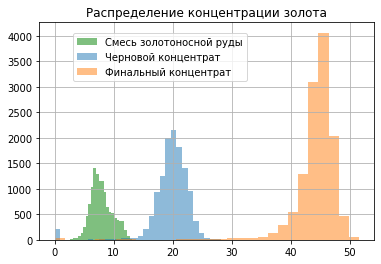

In [637]:
plt.hist(x = data_train['rougher.input.feed_au'], bins = 30, alpha = 0.5,
         label = 'Смесь золотоносной руды', color = 'green')
plt.legend(bbox_to_anchor=(0.1, 0.82), loc=2, borderaxespad=0.)
plt.hist(x = data_train['rougher.output.concentrate_au'], bins = 30, 
         alpha = 0.5, label = 'Черновой концентрат')
plt.legend(bbox_to_anchor=(0.1, 0.95), loc=2, borderaxespad=0.)
plt.hist(x = data_train['final.output.concentrate_au'], bins = 30, 
         alpha = 0.5, label = 'Финальный концентрат')
plt.legend(bbox_to_anchor=(0.1, 0.95), loc=2, borderaxespad=0.)
plt.title('Распределение концентрации золота')
plt.grid(visible = True)

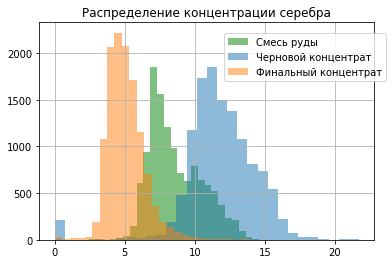

In [638]:
plt.hist(x = data_train['rougher.input.feed_ag'], bins = 30, alpha = 0.5,
         label = 'Смесь руды', color = 'green')
plt.legend(bbox_to_anchor=(0.55, 0.82), loc=2, borderaxespad=0.)
plt.hist(x = data_train['rougher.output.concentrate_ag'], bins = 30, 
         alpha = 0.5, label = 'Черновой концентрат')
plt.legend(bbox_to_anchor=(0.55, 0.95), loc=2, borderaxespad=0.)
plt.hist(x = data_train['final.output.concentrate_ag'], bins = 30, 
         alpha = 0.5, label = 'Финальный концентрат')
plt.legend(bbox_to_anchor=(0.55, 0.95), loc=2, borderaxespad=0.)
plt.title('Распределение концентрации серебра')
plt.grid(visible = True)

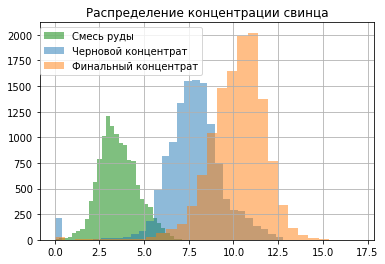

In [639]:
plt.hist(x = data_train['rougher.input.feed_pb'], bins = 30, alpha = 0.5,
         label = 'Смесь руды', color = 'green')
plt.legend(bbox_to_anchor=(0, 0.98), loc=2, borderaxespad=0.)
plt.hist(x = data_train['rougher.output.concentrate_pb'], bins = 30, 
         alpha = 0.5, label = 'Черновой концентрат')
plt.legend(bbox_to_anchor=(0, 0.98), loc=2, borderaxespad=0.)
plt.hist(x = data_train['final.output.concentrate_pb'], bins = 30, 
         alpha = 0.5, label = 'Финальный концентрат')
plt.legend(bbox_to_anchor=(0, 0.98), loc=2, borderaxespad=0.)
plt.title('Распределение концентрации свинца')
plt.grid(visible = True)

По полученным значениям и распределениям можно сделать вывод о том, что концетрация золота при очистке увеличивается, концентрация серебра после очистки снизилось, концентрация свинца увеличивается.

### Распределение размеров гранул сырья

(0.0, 150.0)

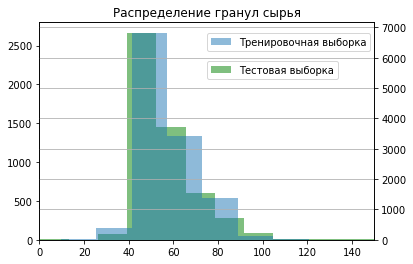

In [640]:
plt.hist(x = data_test['rougher.input.feed_size'], bins = 30, alpha = 0.5,
         label = 'Тестовая выборка', color = 'green')
plt.legend(bbox_to_anchor=(0.5, 0.82), loc=2, borderaxespad=0.)
plt.twinx().hist(x = data_train['rougher.input.feed_size'], bins = 30, 
         alpha = 0.5, label = 'Тренировочная выборка')
plt.legend(bbox_to_anchor=(0.5, 0.95), loc=2, borderaxespad=0.)
plt.title('Распределение гранул сырья')
plt.grid(visible = True)
plt.xlim([0, 150])

Распределения размеров гранул сырья на обучающей и тестовой выборках, значит оценка моделей будет правильной.

<div class="alert alert-success"> 
<h3> Комментарий ревьюера v1</h3>

Да, тут можно и на глазок определить =)

### Исследование суммарной концентрации всех веществ

Создадим столбец с суммарными значениями концентрации всех веществ в ранее созданном датафрейме.

In [641]:
concentrate['sum'] = concentrate['au'] + concentrate['ag'] + concentrate['pb']

In [642]:
concentrate

,name,au,ag,pb,sum
0,Концентрация в смеси золотоносной руды,7.688152,8.148057,3.459495,19.295703
1,Концентрация в черновом концентрате,20.045231,11.729089,7.772689,39.547009
2,Концентрация в финальном концентрате,44.898711,4.916966,10.385437,60.201115


In [643]:
data_train['sum_concentrate_input'] = data_train['rougher.input.feed_au'] + \
                                      data_train['rougher.input.feed_ag'] + \
                                      data_train['rougher.input.feed_pb']

data_train['sum_output_concentrate'] = data_train['rougher.output.concentrate_au'] + \
                                       data_train['rougher.output.concentrate_ag'] + \
                                       data_train['rougher.output.concentrate_pb']

data_train['sum_final_concentrate'] = data_train['final.output.concentrate_au'] + \
                                      data_train['final.output.concentrate_ag'] + \
                                      data_train['final.output.concentrate_pb']

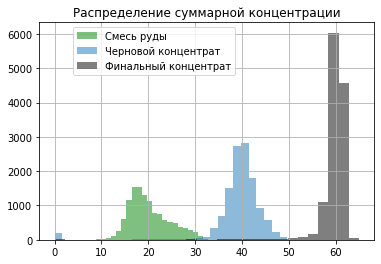

In [644]:
plt.hist(x = data_train['sum_concentrate_input'], bins = 30, alpha = 0.5,
         label = 'Смесь руды', color = 'green')
plt.legend(bbox_to_anchor=(0.1, 0.98), loc=2, borderaxespad=0.)
plt.hist(x = data_train['sum_output_concentrate'], bins = 30, 
         alpha = 0.5, label = 'Черновой концентрат')
plt.legend(bbox_to_anchor=(0.1, 0.98), loc=2, borderaxespad=0.)
plt.hist(x = data_train['sum_final_concentrate'], bins = 30, 
         alpha = 0.5, label = 'Финальный концентрат', color = 'black')
plt.legend(bbox_to_anchor=(0.1, 0.98), loc=2, borderaxespad=0.)
plt.title('Распределение суммарной концентрации')
plt.grid(visible = True)

По полученным значениям концентрации можно сделать вывод о том, что суммарная концентрация повышается на каждом этапе.

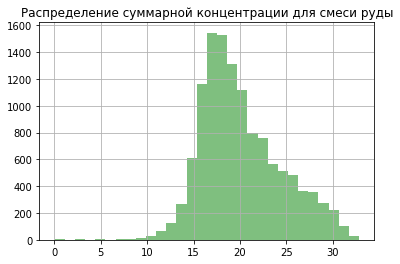

In [645]:
plt.hist(x = data_train['sum_concentrate_input'], bins = 30, alpha = 0.5,
         label = 'Смесь руды', color = 'green')
plt.title('Распределение суммарной концентрации для смеси руды')
plt.grid(visible = True)

По полученному распределению можно заметить, что значения концентрации менее 10 встречаются редко. Удалим эти даннные из обучающей выборки для построения более точной модели.

In [646]:
data_train = data_train.loc[data_train['sum_concentrate_input'] > 10]

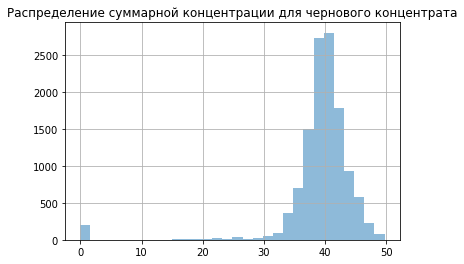

In [647]:
plt.hist(x = data_train['sum_output_concentrate'], bins = 30, 
         alpha = 0.5, label = 'Черновой концентрат')
plt.title('Распределение суммарной концентрации для чернового концентрата')
plt.grid(visible = True)

Также удалим значения концентрации в черновом концентрате менее 20.

In [648]:
data_train = data_train.loc[data_train['sum_output_concentrate'] > 20]

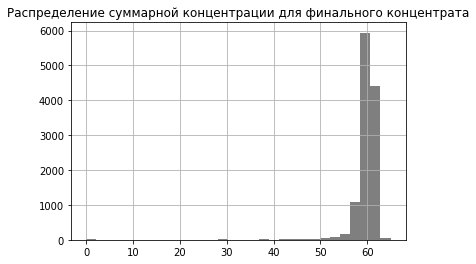

In [649]:
plt.hist(x = data_train['sum_final_concentrate'], bins = 30, 
         alpha = 0.5, label = 'Финальный концентрат', color = 'black')
plt.title('Распределение суммарной концентрации для финального концентрата')
plt.grid(visible = True)

Для данного распределения удалим значения концентрации менее 40.

In [650]:
data_train = data_train.loc[data_train['sum_final_concentrate'] > 40]

В результате из датасета удалены аномальные значения и можно переходить к построению модели.

## Модель

### Функция для вычисления итогового sMAPE

In [651]:
def final_smape(rougher_true, rougher_pred, final_true, final_pred):

# rogher_true - значение эффективности обогащения чернового концентрата
# rougher_pred - предсказанное значение эффективности обогащения чернового концентрата
# final_true - значение эффективности обогащения финального концентрата
# final_pred - предсказанное значение эффективности финального концентрата

    sum_rougher = 0 # суммарное значение по всем объектам для чернового концентрата
    sum_final = 0 # суммарное значение по всем объектам для финального концентрата

    n = len(rougher_true) # количество объектов

# расчет суммы

    for i in range(n):
    # расчет значения для каждого элемента
        rougher_i = (abs(rougher_true[i] - rougher_pred[i]))/((abs(rougher_true[i])
                                                               + abs(rougher_pred[i]))/2)*100 
        final_i = (abs(final_true[i] - final_pred[i]))/((abs(final_true[i]) 
                                                         + abs(final_pred[i]))/2)*100
    # расчет общей суммы
        sum_rougher += rougher_i
        sum_final += final_i
 
# sMAPE для финального концентрата
    smape_rougher = sum_rougher / n 
# sMAPE для финального концентрата
    smape_final = sum_final / n 
    
# итоговое sMAPE
    smape = 0.25 * smape_rougher + 0.75 * smape_final 
    
    return smape

### Обучение моделей

Для обучения модели выберем из тренировочной выборки параметры, соответствующие параметры rougher.

In [652]:
rougher_target = data_train['rougher.output.recovery']

In [653]:
data_train = data_train.drop(columns, axis = 1)

In [654]:
train_columns = data_train.columns

На данном этапе выберем признаки для построения моделей. Признаки были выбраны с учетом того, какие значения доступны на этапе флотации.

In [655]:
rougher_columns = []
for i in train_columns:
    if 'rougher' in i:
        rougher_columns.append(i)
print(*rougher_columns, sep = '\n')

rougher.input.feed_ag
rougher.input.feed_pb
rougher.input.feed_rate
rougher.input.feed_size
rougher.input.feed_sol
rougher.input.feed_au
rougher.input.floatbank10_sulfate
rougher.input.floatbank10_xanthate
rougher.input.floatbank11_sulfate
rougher.input.floatbank11_xanthate
rougher.state.floatbank10_a_air
rougher.state.floatbank10_a_level
rougher.state.floatbank10_b_air
rougher.state.floatbank10_b_level
rougher.state.floatbank10_c_air
rougher.state.floatbank10_c_level
rougher.state.floatbank10_d_air
rougher.state.floatbank10_d_level
rougher.state.floatbank10_e_air
rougher.state.floatbank10_e_level
rougher.state.floatbank10_f_air
rougher.state.floatbank10_f_level


Сосотавим выборку для построения модели с учетом выбранных параметров.

In [656]:
rougher_params = data_train[rougher_columns]

Перейдем к построению моделей. Для наилучшего результата построим две модели - с помощью алгоритма линейной регрессии и с помощью случайного леса.

In [657]:
linreg_rougher = LinearRegression().fit(rougher_params, rougher_target)

In [658]:
pred_linreg = linreg_rougher.predict(rougher_params)

In [659]:
rougher_target = pd.Series(rougher_target).reset_index(drop=True)
result_linreg = pd.Series(pred_linreg)

In [660]:
rmse_linreg = mean_squared_error(rougher_target, pred_linreg)**0.5
print('RMSE для линейной регрессии: {:.3f}'.format(rmse_linreg))

RMSE для линейной регрессии: 5.254


In [661]:
rand_for = RandomForestRegressor(random_state=123)
rand_for.fit(rougher_params, rougher_target)

RandomForestRegressor(random_state=123)

In [662]:
pred_rand_for = rand_for.predict(rougher_params)

In [663]:
rmse_rand_for = mean_squared_error(rougher_target, pred_rand_for)**0.5
print('RMSE для случайного леса: {:.3f}'.format(rmse_rand_for))

RMSE для случайного леса: 1.138


Построение модели будем осуществлять с помощью случайного леса. Подберем гиперпараметры модели.

In [664]:
params = [ {'max_depth': list(range(3,6)), 'random_state' : [123],
            'n_estimators' : list(range(60, 65, 1))}]

In [665]:
model_forest = GridSearchCV(RandomForestRegressor(), param_grid = params, cv = 5, verbose=True,
                            n_jobs=-1)

In [666]:
model_forest = model_forest.fit(rougher_params, rougher_target)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


In [667]:
model_forest.best_estimator_

RandomForestRegressor(max_depth=5, n_estimators=62, random_state=123)

In [668]:
forest_result = model_forest.predict(rougher_params)

С помощью полученной модели получим значения эффективности обогащения на этапе флотации для тренировочной выборки и для полной выборки

In [669]:
data_train['rougher_recovery'] = forest_result

In [670]:
full = data_full[rougher_columns]

In [671]:
rougher_recovery = model_forest.predict(full)

In [672]:
data_full['rougher_recovery'] = rougher_recovery

Перейдем к построению модели для определения финальной эффективности обогащения руды.

Создадим массив из параметров, которые уже были использованы для построения первой модели.

In [673]:
col_rougher = rougher_params.columns
col_rougher

Index(['rougher.input.feed_ag', 'rougher.input.feed_pb',
       'rougher.input.feed_rate', 'rougher.input.feed_size',
       'rougher.input.feed_sol', 'rougher.input.feed_au',
       'rougher.input.floatbank10_sulfate',
       'rougher.input.floatbank10_xanthate',
       'rougher.input.floatbank11_sulfate',
       'rougher.input.floatbank11_xanthate', 'rougher.state.floatbank10_a_air',
       'rougher.state.floatbank10_a_level', 'rougher.state.floatbank10_b_air',
       'rougher.state.floatbank10_b_level', 'rougher.state.floatbank10_c_air',
       'rougher.state.floatbank10_c_level', 'rougher.state.floatbank10_d_air',
       'rougher.state.floatbank10_d_level', 'rougher.state.floatbank10_e_air',
       'rougher.state.floatbank10_e_level', 'rougher.state.floatbank10_f_air',
       'rougher.state.floatbank10_f_level'],
      dtype='object')

Сохраним в отдельной переменной значения целевой переменной.

In [674]:
final_recovery = data_full['final.output.recovery']

Соберем перечень параметров для создания модели с учетом параметров, доступных на этом этапе.

In [675]:
test_columns = data_test.columns
final_columns = []
for i in test_columns:
    if 'secondary_cleaner' in i or 'primary_cleaner' in i:
        final_columns.append(i)
final_columns.append('rougher_recovery')
print(*final_columns, sep = '\n')

primary_cleaner.input.sulfate
primary_cleaner.input.depressant
primary_cleaner.input.feed_size
primary_cleaner.input.xanthate
primary_cleaner.state.floatbank8_a_air
primary_cleaner.state.floatbank8_a_level
primary_cleaner.state.floatbank8_b_air
primary_cleaner.state.floatbank8_b_level
primary_cleaner.state.floatbank8_c_air
primary_cleaner.state.floatbank8_c_level
primary_cleaner.state.floatbank8_d_air
primary_cleaner.state.floatbank8_d_level
secondary_cleaner.state.floatbank2_a_air
secondary_cleaner.state.floatbank2_a_level
secondary_cleaner.state.floatbank2_b_air
secondary_cleaner.state.floatbank2_b_level
secondary_cleaner.state.floatbank3_a_air
secondary_cleaner.state.floatbank3_a_level
secondary_cleaner.state.floatbank3_b_air
secondary_cleaner.state.floatbank3_b_level
secondary_cleaner.state.floatbank4_a_air
secondary_cleaner.state.floatbank4_a_level
secondary_cleaner.state.floatbank4_b_air
secondary_cleaner.state.floatbank4_b_level
secondary_cleaner.state.floatbank5_a_air
secondary

Соберем обучающую и тренировочную выборки с учетом параметров из датасета data_full. Для этого добавим необходимые параметры в датасет.

In [676]:
data_final_train = data_train[final_columns]
data_final_train['date'] = data_train['date']

In [677]:
data_final_train.shape

(11867, 32)

In [678]:
target = data_full[['date', 'final.output.recovery', 'rougher_recovery', 'rougher.output.recovery']]

In [679]:
target.shape

(16094, 4)

In [680]:
data_train = pd.merge(data_final_train, target,how='inner')
rougher_recovery_true_train = data_train['rougher.output.recovery']
data_train = data_train.drop(['date', 'rougher.output.recovery'], axis = 1)

In [681]:
data_train.shape

(10656, 32)

In [682]:
data_train.columns

Index(['primary_cleaner.input.sulfate', 'primary_cleaner.input.depressant',
       'primary_cleaner.input.feed_size', 'primary_cleaner.input.xanthate',
       'primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.state.floatbank8_a_level',
       'primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_b_level',
       'primary_cleaner.state.floatbank8_c_air',
       'primary_cleaner.state.floatbank8_c_level',
       'primary_cleaner.state.floatbank8_d_air',
       'primary_cleaner.state.floatbank8_d_level',
       'secondary_cleaner.state.floatbank2_a_air',
       'secondary_cleaner.state.floatbank2_a_level',
       'secondary_cleaner.state.floatbank2_b_air',
       'secondary_cleaner.state.floatbank2_b_level',
       'secondary_cleaner.state.floatbank3_a_air',
       'secondary_cleaner.state.floatbank3_a_level',
       'secondary_cleaner.state.floatbank3_b_air',
       'secondary_cleaner.state.floatbank3_b_level',
       'secondary_cleaner.state.

In [683]:
data_final_train.shape

(11867, 32)

In [684]:
target_train_true = data_train['final.output.recovery'] # целевой признак в тренировочной выборке
feature_final_train = data_train[final_columns] # переменные для обучения модели

In [685]:
feature_final_train.shape

(10656, 31)

In [686]:
target = data_full[['date', 'final.output.recovery', 'rougher_recovery', 'rougher.output.recovery']]

In [687]:
data_test = pd.merge(data_test, target, how='inner')
rougher_recovery_true = data_test['rougher.output.recovery']
data_test = data_test.drop(['date', 'rougher.output.recovery'], axis = 1)

In [688]:
target_test_true = data_test['final.output.recovery'] # целевой признак в тестовой выборке
feature_final_test = data_test[final_columns] # переменные тестовой выборки

In [689]:
target_train_true.shape

(10656,)

In [690]:
feature_final_train.shape

(10656, 31)

In [691]:
target_test_true.shape

(5077,)

In [692]:
feature_final_test.shape

(5077, 31)

Построим модель линейной регрессий и случайного леса, выберем наиболее точную из них по значению sMAPE.

In [693]:
model_lr = LinearRegression().fit(feature_final_train, target_train_true)

In [694]:
lr_result = model_lr.predict(feature_final_test)

Рассчитаем значение sMAPE на тестовой выборке по данным, полученным с помощью линейной регрессии.

In [695]:
lr_pred = model_lr.predict(feature_final_train)
lr_rougher_pred = feature_final_train['rougher_recovery']

In [696]:
final_smape(rougher_recovery_true_train, lr_rougher_pred, target_train_true, lr_pred)

6.083032814989257

Перейдем к построению модели с помощью алгоритма случайного леса. При этом подберем оптимальные параметры для модели.

In [697]:
params = [ {'max_depth': list(range(4,7)), 'n_estimators': list(range(37, 47, 5)), 
            'random_state' : [123], }]

In [698]:
best_model = GridSearchCV( RandomForestRegressor(), param_grid = params, cv = 5, verbose=True, n_jobs=-1)

In [699]:
best_model = best_model.fit(feature_final_train, target_train_true)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


In [700]:
pred_randfor_final = best_model.predict(feature_final_test)

In [701]:
best_model.best_estimator_

RandomForestRegressor(max_depth=4, n_estimators=37, random_state=123)

Вычислим sMAPE для значений, полученных с помощью алгоритма слуайного леса.

In [702]:
pred_randfor_train = best_model.predict(feature_final_train)
final_smape(rougher_recovery_true_train, lr_rougher_pred, target_train_true, pred_randfor_train)

5.932037644589392

Наименьшее значение было получено с помощью модели случайного леса.

Вычислим значение метрики на тестовой выборке, использую полученную модель.

In [703]:
rougher_pred = feature_final_test['rougher_recovery']

In [704]:
final_smape(rougher_recovery_true, rougher_pred, target_test_true, pred_randfor_final)

7.985248798653486

# Общий вывод

В ходе работы была выполнена подготовка данных, проведен анализ данных и построена модель для прогнозирования целевого признака.<br>
При анализе данных выяснилось, что концетрация золота и свинца при очистке увеличивается, концентрация серебра после очистки снижается. По полученному распределению суммарной концентрации металлов можно сделать вывод о том, что с каждым этапов значение концентрации увеличивается.<br>
По подготовленным данным с помощью алгоритма случайного леса были построены модели для прогнозирования целевого признака. В результате на тестовой выборке было получено значение метрики sMAPE, равное 7,99 %.
